### Data Cleaning & EDA 
In this workbook I will clean, prepare and explore the data prior to running the data through some classification modeling in the next workbook.
 
Data Cleaning Overview:
1. Load the data from the collection workbook 
2. View the data & check for null values 
3. Lowercase the titles
4. Remove URLs, duplicates, and titles with too few words to be meaningful

Data Exploration Overview:
1. Review the distribution of word counts and interquartile range
2. Analyze what percentage of posts are by the same author to ensure that we have a wide range of voices captured.
3. Count Vectorize the titles and examine which words are used most frequently by Democrats and Republicans. Are there certain topics that overlap and vary from group to group?
4. Sentiment Analysis- What do users feel positive and negatively about?

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
%store -r demdata
%store -r repdata

In [3]:
#check for null values
print(f'Dem nulls:\n{demdata.isnull().sum().sum()}')

print(f'Rep nulls:\n{repdata.isnull().sum().sum()}')

Dem nulls:
0
Rep nulls:
0


In [4]:
#lowercase the title
demdata['title'] = demdata['title'].str.lower()
repdata['title'] = repdata['title'].str.lower()

In [5]:
#Removing the urls from title feature
#Reviewed code from a blog https://bobbyhadz.com/blog/python-remove-url-from-text
demdata['title'] = [re.sub(r'http\S+', '', title) for title in demdata['title']]
repdata['title'] = [re.sub(r'http\S+', '', title) for title in repdata['title']]

In [6]:
#Drop Duplicate Rows
demdata.drop_duplicates(inplace= True)
repdata.drop_duplicates(inplace= True)

In [7]:
#Create another feature to analyze word count for the titles
demdata['title_word_count']= demdata['title'].str.split(' ').apply(len)
repdata['title_word_count']= repdata['title'].str.split(' ').apply(len)

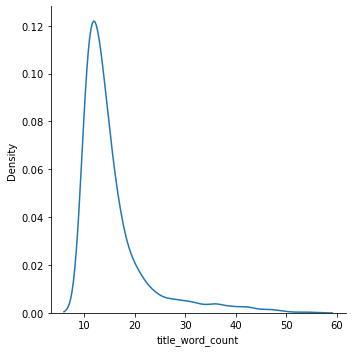

In [8]:
#Observe the Distribution of Word Counts in Title
sns.displot(demdata['title_word_count'],kind = 'kde');

In [9]:
#Going to remove titles with less than 9 words (interquartile range) as I don't think titles with fewer words will be meaningful
#Both for purposes of analysis and prediction
demdata['title_word_count'].describe()

count    3408.000000
mean       15.518192
std         6.888071
min        10.000000
25%        11.000000
50%        13.000000
75%        17.000000
max        55.000000
Name: title_word_count, dtype: float64

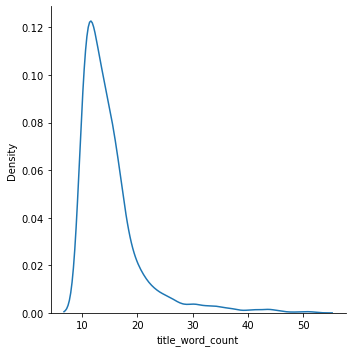

In [10]:
sns.displot(repdata['title_word_count'],kind = 'kde');

In [11]:
repdata['title_word_count'].describe()

count    4173.000000
mean       15.109034
std         5.751222
min        10.000000
25%        11.000000
50%        14.000000
75%        17.000000
max        52.000000
Name: title_word_count, dtype: float64

In [12]:
#Removing rows where title is less than 5 words because these posts don't have enough words to gather meaningful insight
demdata = demdata[demdata['title_word_count'] > 9]
repdata = repdata[repdata['title_word_count'] > 9]

In [13]:
demdata.shape

(3408, 5)

In [14]:
repdata.shape

(4173, 5)

#### Posts by Author
Ideally my data would be composed of the same number of posts by a large number of different authors. Unfortunately as seen below there are a few authors in each subreddit who composed more than 10% of the posts in each subreddit. A potential concern here is that these few individuals are clouding the results of my EDA and rather than identifying topics that most Democrats or Republicans care about I may be overweighing the opinions of these few.

In [15]:
#Reviewing the number of unique authors
print(f"Number of Unique Democrat Redditors: {len(demdata['author'].unique())}")
print(f"Number of Unique Republican Redditors: {len(repdata['author'].unique())}")

Number of Unique Democrat Redditors: 591
Number of Unique Republican Redditors: 431


In [16]:
'''I acknowledge that 10% is a bit high for further enhancements to topic evaluation 
we should consider limiting the number of posts per user.'''

demdata['author'].value_counts(normalize = True).head(20)

imll99             0.102113
BlankVerse         0.084800
Free_Swimming      0.046948
1000000students    0.037265
Souled_Out         0.036092
jonfla             0.031690
LolAtAllOfThis     0.025235
agjrpsl            0.025235
Paneraiguy1        0.019660
tyrannosauru       0.017019
gotostep2          0.016725
progress18         0.016138
Watchdogs66        0.016138
semaphore-1842     0.014965
shallah            0.014085
realplayer16       0.013498
backpackwayne      0.013204
audiomuse1         0.012617
coffeespeaking     0.012031
A-Wise-Cobbler     0.011444
Name: author, dtype: float64

In [17]:
#same note as above
repdata['author'].value_counts(normalize = True).head(20)

intelligentreviews    0.134436
saurin212             0.117661
BroSteveWinter        0.072370
SnooBooks5387         0.066379
Dan-In-SC             0.052960
tbburns2017           0.051522
red_alert_22          0.029236
Super-CR              0.024203
BeatWorld             0.023245
mperrault23           0.021088
Redbean01             0.015097
RedBaronsBrother      0.012221
Beliavsky             0.010544
MattPalumbo           0.010544
Alekscako             0.009825
yuri_2022             0.009825
DailyConservative     0.009585
IamShado              0.008627
jinladen040           0.007908
Patriots-United       0.007668
Name: author, dtype: float64

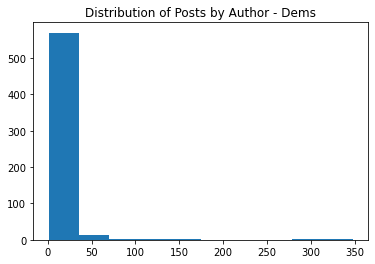

In [18]:
#majority of users have fewer than 50 posts captured by our pull
plt.hist(demdata['author'].value_counts())
plt.title('Distribution of Posts by Author - Dems');

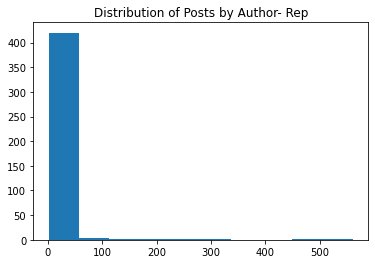

In [19]:
plt.hist(repdata['author'].value_counts())
plt.title('Distribution of Posts by Author- Rep');

#### Exploratory Data Analysis

As part of exploratory analysis I will count vectorize the title so that I can analyze which words are being used most frequently within each subreddit. I will also apply the vader sentiment analysis to see which topics republicans and democrats have strong positive or negative opinions on. Lastly I will explore which topics are receiving the highest level engagement using the number of comments.

In [20]:
#Instantiating and applying a Count Vectorizer removing the stop words
dem_vec = CountVectorizer(stop_words = 'english')

X_dem= demdata['title']

X_dem= dem_vec.fit_transform(X_dem)

demdf = pd.DataFrame(X_dem.todense(), columns = dem_vec.get_feature_names_out())

In [21]:
rep_vec = CountVectorizer(stop_words = 'english')

X_rep= repdata['title']

X_rep= rep_vec.fit_transform(X_rep)

repdf = pd.DataFrame(X_rep.todense(), columns = rep_vec.get_feature_names_out())

In [22]:
#Top 50 Words in Democrat Subreddit
demdf.sum().sort_values(ascending = False).head(15)

trump          723
biden          448
house          276
says           255
democrats      250
gop            243
president      200
new            186
white          180
court          179
republicans    165
abortion       161
senate         152
election       148
republican     142
dtype: int64

In [23]:
#Top 50 Words in Republican Subreddit
repdf.sum().sort_values(ascending = False).head(15)

biden        879
trump        532
new          268
says         242
fbi          217
democrats    169
gop          169
election     160
joe          159
hunter       159
twitter      156
musk         152
house        152
desantis     146
inflation    134
dtype: int64

In [24]:
#Creating a table to make various comparisons between subreddits and visualizations for my presentation

bardf = pd.concat([demdata, repdata], axis = 0)

bardf.reset_index(inplace = True, drop = True)

bar_vec = CountVectorizer(stop_words = 'english')

X_bar= bardf['title']

X_bar= bar_vec.fit_transform(X_bar)

bar_df = pd.DataFrame(X_bar.todense(), columns = bar_vec.get_feature_names_out())

bar_df['target_var'] = bardf['subreddit']

bar_df.groupby('target_var').sum().head(50)

,00,000,01,02,03,04,041522,042122,042822,05,...,zooey,zuck,zuckbucks,zuckerberg,zuckerbucks,über,ŀibєɾɑls,ŀєɑdєɾ,ŀєɑk,ɑs
target_var,,,,,,,,,,,,,,,,,,,,,
Republican,0,41,0,0,0,2,3,1,1,3,...,0,3,1,12,2,1,1,1,1,2
democrats,6,43,4,1,2,0,0,0,0,0,...,1,0,0,2,0,0,0,0,0,0


In [25]:
compare_df = bar_df.groupby('target_var').sum().T
compare_df.head()

target_var,Republican,democrats
00,0,6
000,41,43
01,0,4
02,0,1
03,0,2


In [44]:
#Identifying what democrats talk about but republicans do not

#Create a new feature for the difference between word counts between subreddits
compare_df['difference'] = abs(compare_df['Republican'] - compare_df['democrats'])

#Filter for words where one sub rarely mentions the word and identify biggest differences
compare_df[compare_df['Republican'] < 20].sort_values(by = 'difference', ascending = False).head(10)

target_var,Republican,democrats,difference
abbott,17,55,38
voting,16,51,35
sheet,0,33,33
jobs,8,38,30
statement,12,41,29
care,14,41,27
greg,8,35,27
beto,1,28,27
michigan,17,43,26
general,17,43,26


In [28]:
#What republicans talk about that democrats do not
compare_df[compare_df['democrats'] < 20].sort_values(by = 'difference', ascending = False).head(10)

target_var,Republican,democrats,difference
hunter,159,0,159
twitter,156,18,138
musk,152,14,138
elon,132,12,120
border,91,16,75
raid,79,13,66
illegal,76,10,66
woke,69,5,64
daily,62,5,57
laptop,52,0,52


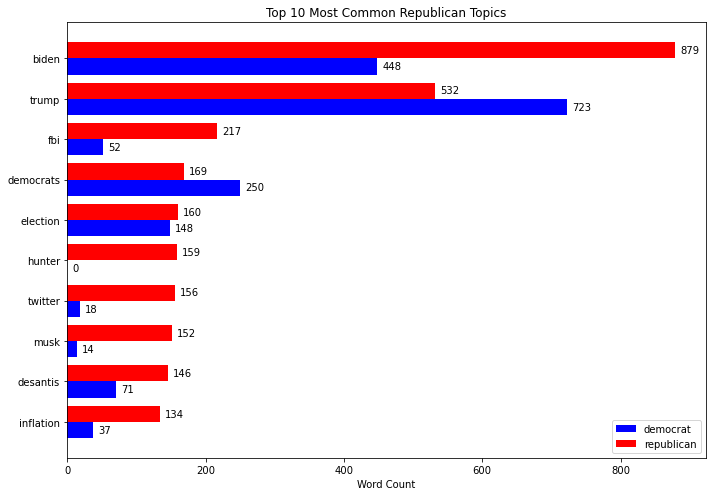

In [30]:
#Comparing Word Counts for Top 10 Republican Topics
labels = ['inflation','desantis','musk','twitter','hunter','election','democrats','fbi','trump','biden']

democrat = [37,71,14,18,0,148,250,52,723,448]
republican = [134,146,152,156,159,160,169,217,532,879]


x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize = (10, 7))

dembar = ax.barh(x - width/2, democrat, width, label='democrat', color = 'blue')
repbar = ax.barh(x + width/2, republican, width, label='republican', color = 'red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Word Count')
ax.set_title('Top 10 Most Common Republican Topics')
ax.set_yticks(x, labels)
ax.legend()

ax.bar_label(repbar, padding=5)
ax.bar_label(dembar, padding=5)


fig.tight_layout()

plt.show()


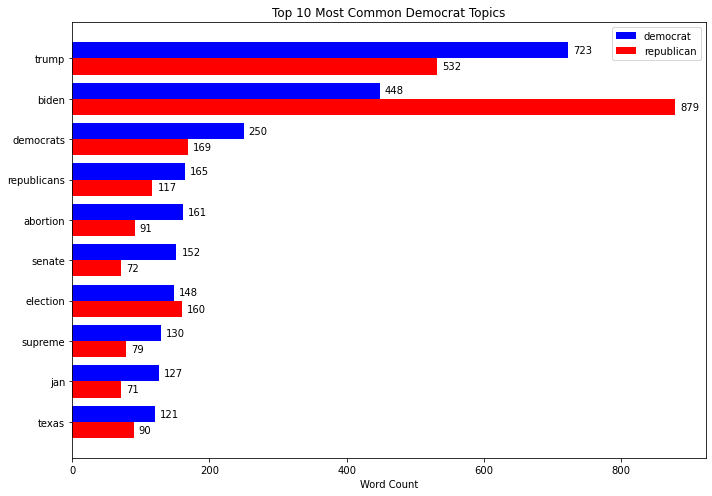

In [31]:
#Comparing Word Counts for Top 10 Democrat Topics
labels = ['texas','jan','supreme','election','senate','abortion','republicans','democrats','biden','trump']

democrat = [121,127,130,148,152,161,165,250,448,723]
republican = [90,71,79,160,72,91,117,169,879,532]


x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize = (10, 7))

dembar = ax.barh(x + width/2, democrat, width, label='democrat', color = 'blue')
repbar = ax.barh(x - width/2, republican, width, label='republican', color = 'red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Word Count')
ax.set_title('Top 10 Most Common Democrat Topics')
ax.set_yticks(x, labels)
ax.legend()

ax.bar_label(repbar, padding=5)
ax.bar_label(dembar, padding=5)


fig.tight_layout()

plt.show()

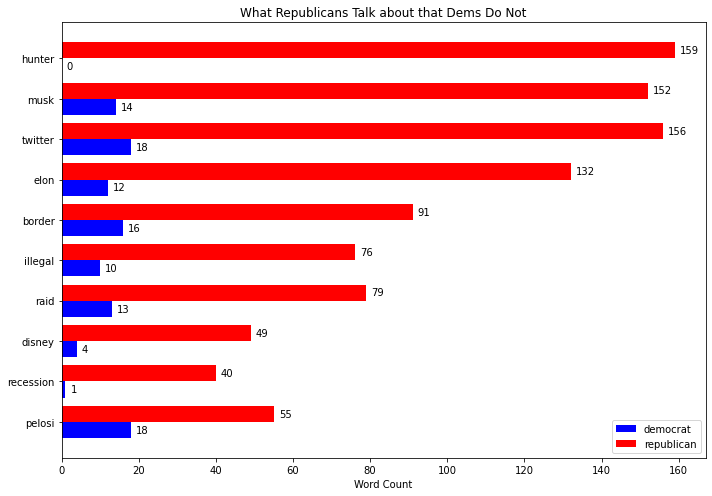

In [32]:
#Topics Republicans are talking about but Democrats are not

labels = ['pelosi','recession','disney','raid','illegal','border','elon','twitter','musk','hunter']

democrat = [18,1,4,13,10,16,12,18,14,0]
republican = [55,40,49,79,76,91,132,156,152,159]


x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize = (10, 7))

dembar = ax.barh(x - width/2, democrat, width, label='democrat', color = 'blue')
repbar = ax.barh(x + width/2, republican, width, label='republican', color = 'red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Word Count')
ax.set_title('What Republicans Talk about that Dems Do Not')
ax.set_yticks(x, labels)
ax.legend()

ax.bar_label(repbar, padding=5)
ax.bar_label(dembar, padding=5)


fig.tight_layout()

plt.show()

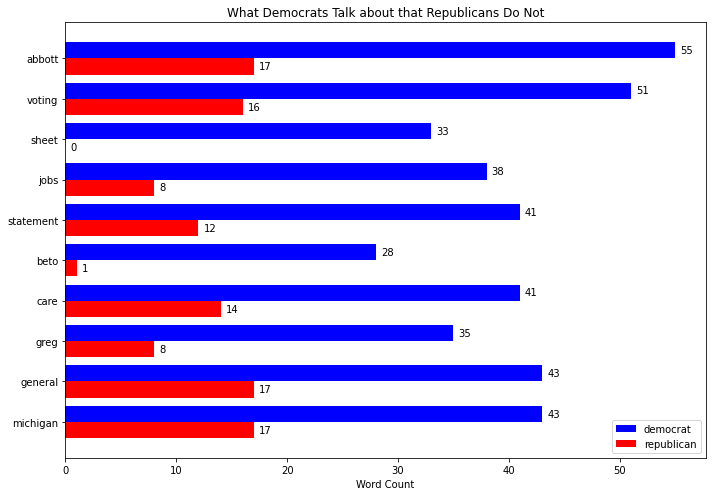

In [33]:
#Topics Democrats are talking about but Republicans are not

labels = ['michigan','general','greg','care','beto','statement','jobs','sheet','voting','abbott']
democrat = [43,43,35,41,28,41,38,33,51,55]
republican = [17,17,8,14,1,12,8,0,16,17]


x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize = (10, 7))

dembar = ax.barh(x + width/2, democrat, width, label='democrat', color = 'blue')
repbar = ax.barh(x - width/2, republican, width, label='republican', color = 'red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Word Count')
ax.set_title('What Democrats Talk about that Republicans Do Not')
ax.set_yticks(x, labels)
ax.legend()

ax.bar_label(repbar, padding=5)
ax.bar_label(dembar, padding=5)


fig.tight_layout()

plt.show()

### Sentiment Analysis

In [35]:
# Instantiate Sentiment Intensity Analyzer
sent = SentimentIntensityAnalyzer()

#get the sentiment scores for each post in each subreddit
dem_sent= [sent.polarity_scores(post) for post in demdata['title']]
rep_sent= [sent.polarity_scores(post) for post in repdata['title']]

tempdf_dem= pd.DataFrame.from_dict(dem_sent)
tempdf_rep = pd.DataFrame.from_dict(rep_sent)

tempdf_dem.head()

,neg,neu,pos,compound
0,0.255,0.588,0.157,-0.2500
1,0.181,0.819,0.000,-0.4767
2,0.000,0.753,0.247,0.5574
3,0.000,1.000,0.000,0.0000
4,0.000,0.769,0.231,0.5994


In [36]:
#Reset the index for each subreddit 
demdata.reset_index(drop= True, inplace= True)
repdata.reset_index(drop= True, inplace= True)

#Combine the Sentiment Scores with the dem and rep data sets
dem_sentdf = demdata.merge(tempdf_dem, left_index = True, right_index = True)
rep_sentdf = repdata.merge(tempdf_rep, left_index = True, right_index = True)

In [45]:
#Identify top 10 highest positive score posts for dems
dem_sentdf[['title', 'neg', 'neu', 'pos', 'compound']].sort_values(by= 'pos', ascending = False).head(10)

,title,neg,neu,pos,compound
774,we can make the super rich pay their fair shar...,0.072,0.309,0.619,0.8910
3148,biden's supreme court choice: a political prom...,0.000,0.419,0.581,0.8271
3250,hey guys i hope you like my obama fan art,0.000,0.438,0.562,0.7717
3179,supreme court justice stephen breyer to retire...,0.000,0.441,0.559,0.8860
3309,democrat sheila cherfilus-mccormick wins flori...,0.000,0.455,0.545,0.8625
2922,"evers creates commission to improve services, ...",0.000,0.476,0.524,0.7717
1446,"tiktok promises republicans ""it’s working to p...",0.000,0.479,0.521,0.7650
2636,watching a new national hero emerge is a power...,0.000,0.484,0.516,0.7506
1178,democrats boost far-right candidates in hopes ...,0.000,0.488,0.512,0.8126
3247,"governor tony evers grants 54 pardons, brings ...",0.000,0.491,0.509,0.7430


In [46]:
#Identify top 10 highest positive score posts for reps
rep_sentdf[['title', 'neg', 'neu', 'pos', 'compound']].sort_values(by= 'pos', ascending = False).head(10)

,title,neg,neu,pos,compound
2502,"the us loves a winner, not a whiner, joe biden",0.000,0.348,0.652,0.8551
1626,the perfect gift for trump supporters! 80% off...,0.000,0.364,0.636,0.9323
1633,the perfect gift for trump loving patriots! 80...,0.000,0.392,0.608,0.9323
261,most republicans support declaring the united ...,0.000,0.449,0.551,0.8214
3246,exclusive twitter set to accept musk's 'best a...,0.000,0.458,0.542,0.8074
1612,gop gambit could help u.s. energy producers bu...,0.000,0.476,0.524,0.7717
1831,"tiktok promises republicans ""it’s working to p...",0.000,0.479,0.521,0.7650
1630,🇺🇸the best accessory for a any true patriot's ...,0.000,0.490,0.510,0.8070
2028,the supreme court's gun decision is a huge win...,0.126,0.366,0.508,0.8074
60,falsehood spreads about florida gov. desantis’...,0.000,0.503,0.497,0.7845


In [47]:
#Identify top 10 highest negative score posts for dems
dem_sentdf[['title', 'neg', 'neu', 'pos', 'compound']].sort_values(by= 'neg', ascending = False).head(10)

,title,neg,neu,pos,compound
950,senate democrats strike a blow against cynicis...,0.624,0.376,0.000,-0.8074
2389,russia-ukraine war: russia threatens to intens...,0.607,0.393,0.000,-0.9169
190,it's been wild democrats. i got suspended for ...,0.602,0.398,0.000,-0.8910
1490,the afghan refugee crisis collides with the am...,0.595,0.405,0.000,-0.8834
2974,"donald trump's terrible, horrible, no good, ve...",0.586,0.279,0.135,-0.8655
286,democrats waste no time using graham's 15-week...,0.583,0.417,0.000,-0.8807
1368,"‘stunned, outraged, and deeply saddened’: bide...",0.580,0.420,0.000,-0.9014
12,herschel walker’s campaign in turmoil as adult...,0.579,0.421,0.000,-0.9081
2066,buffalo suspect embraced racist 'replacement' ...,0.578,0.422,0.000,-0.8625
2031,madison cawthorn loses primary after brutal ba...,0.571,0.429,0.000,-0.8519


In [48]:
#Identify top 10 highest negative score posts for reps
rep_sentdf[['title', 'neg', 'neu', 'pos', 'compound']].sort_values(by= 'neg', ascending = False).head(10)

,title,neg,neu,pos,compound
1777,"chicago crime, murder &amp; mayhem | criminal ...",0.704,0.296,0.0,-0.9168
2221,jan. 6 prisoner who was denied cancer treatmen...,0.663,0.337,0.0,-0.9300
519,do the democrats have a . . . murder problem?,0.649,0.351,0.0,-0.8126
16,this dipshit is stupid as fuck doesn’t even de...,0.648,0.352,0.0,-0.9168
1527,netflix 'resident evil' series destroyed on ro...,0.631,0.369,0.0,-0.9287
1535,police seeking 3 suspects who violently attack...,0.617,0.383,0.0,-0.9169
1985,states reject federal gun control bill as gop ...,0.611,0.389,0.0,-0.8750
2755,democrats deserve to be completely destroyed i...,0.597,0.403,0.0,-0.9571
1669,fauci says attacking puppy torture is an attac...,0.588,0.412,0.0,-0.8750
1716,three suspects arrested for murdering michigan...,0.583,0.417,0.0,-0.8689


In [41]:
#Identify top 10 highest compound score posts for dems
dem_sentdf[['title', 'neg', 'neu', 'pos', 'compound']].sort_values(by= 'compound', ascending = False).head(10)

,title,neg,neu,pos,compound
3180,governor cooper and attorney general stein fil...,0.00,0.567,0.433,0.9741
895,wounded warrior project says signing of honori...,0.03,0.659,0.311,0.9423
3400,justice department announces new rule to help ...,0.00,0.521,0.479,0.9393
1400,governor mills signs executive order to safegu...,0.00,0.648,0.352,0.9349
25,"in the span of a week, marco rubio voted again...",0.00,0.603,0.397,0.9100
3122,uc berkeley economists have launched a new too...,0.00,0.762,0.238,0.9081
1195,michigan senate democrats have a chance to win...,0.00,0.785,0.215,0.9062
2093,chief justice john roberts could persuade anot...,0.00,0.723,0.277,0.8979
68,trump country labor markets faring better in t...,0.00,0.748,0.252,0.8957
497,trump says he's 'financially supporting' janua...,0.00,0.592,0.408,0.8932


In [49]:
#Identify top 10 highest compound score posts for reps
rep_sentdf[['title', 'neg', 'neu', 'pos', 'compound']].sort_values(by= 'compound', ascending = False).head(10)

,title,neg,neu,pos,compound
1633,the perfect gift for trump loving patriots! 80...,0.000,0.392,0.608,0.9323
1626,the perfect gift for trump supporters! 80% off...,0.000,0.364,0.636,0.9323
1949,"slowly but surely, it will one day be socially...",0.000,0.672,0.328,0.9136
3568,i am playing the sims 2 and my sim is best fri...,0.000,0.654,0.346,0.9042
2934,join stereo! great app! below is my link to my...,0.000,0.593,0.407,0.8997
2198,uvalde superintendent says district to hire mo...,0.000,0.725,0.275,0.8915
2824,victor davis hanson’s magnum opus -- the best ...,0.000,0.727,0.273,0.8885
90,russian spy awarded presidential medal of free...,0.000,0.545,0.455,0.8750
2290,new supreme court justice jackson could be in ...,0.093,0.484,0.422,0.8591
2502,"the us loves a winner, not a whiner, joe biden",0.000,0.348,0.652,0.8551


In [43]:
%store demdata
%store repdata

Stored 'demdata' (DataFrame)
Stored 'repdata' (DataFrame)
